In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import os,datetime,warnings

import tensorflow as tf
import pandas as pd
import seaborn as sns

from keras.models import Model,Sequential
from keras.layers import Dense,LSTM,Conv2D,Conv2DTranspose,Dropout,GRU,Activation,Add,Concatenate,BatchNormalization,Bidirectional,Embedding,Flatten

from contextlib import closing
import io
import dropbox

from tweepy import API,OAuthHandler
import json

warnings.filterwarnings('ignore')
sns.set()

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def remove_user(tweet):
    pieces = tweet.lstrip().split('@')
    fulltext = pieces[0]
    if len(pieces)>1:
        for piece in pieces[1:]:
            subarray = piece.split(' ',1)
            if len(subarray)==1:
                continue
            fulltext = fulltext+'USER '+subarray[1]
    return fulltext

def remove_link(tweet):
    pieces = tweet.split('http')
    fulltext = pieces[0]
    if len(pieces)>1:
        for piece in pieces[1:]:
            subarray = piece.split(' ',1)
            if len(subarray)==1:
                continue
            fulltext = fulltext+'LINK '+subarray[1]
    return fulltext

In [4]:
with open('..\\..\\AUTH\\dropbox_auth.txt','r') as file:
    access_token = file.readline()
dbx = dropbox.Dropbox(access_token)
metadata,res = dbx.files_download(path='/TF_data/TURING/tweets.csv')

In [5]:
with open('..\\..\\AUTH\\path_to_dropbox.txt','r') as file:
    mypath = file.readline()

In [6]:
df = pd.read_csv(mypath+'TURING\\tweets.csv', encoding='latin-1', header=None)
df = df.drop(columns=[0,1,3]).rename(columns={2:'Time',4:'User',5:'Tweet'})
df['Weekday'] = df['Time'].apply(lambda x: x[:3]).astype('category').cat.codes
df['Tweet'] = df['Tweet'].apply(lambda x: remove_user(x.lower())).apply(lambda x: remove_link(x))
df['Tweet'] = df['Tweet'].apply(lambda x: x.replace('.','').replace('!','').replace('-','').replace('\'','').replace(';','').replace('?','').replace('(','').replace(')',''))

In [7]:
word_dict = dict()

for tweet in df['Tweet'].values:
    wordset = set(tweet.split(' '))
    for word in wordset:
        if word=='': continue
        if word in word_dict.keys(): word_dict[word] += 1
        else: word_dict[word] = 1

In [8]:
sorted_word_dict = dict(sorted(word_dict.items(),key=(lambda x: x[1]),reverse=True))

In [13]:
fdict = dict()

fdict['__DEFAULT__'] = 0
code = 1
for k,v in sorted_word_dict.items():
    if v>50: 
        fdict[k]=code
        code += 1

In [14]:
encoded_col = []
for tweet in df['Tweet'].values:
    wlist = []
    wordset = set(tweet.split(' '))
    for word in wordset:
        try:
            wlist.append(fdict[word])
        except:
            wlist.append(fdict['__DEFAULT__'])
    encoded_col.append(wlist)
df['Encoded'] = encoded_col

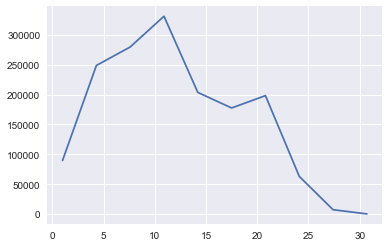

In [15]:
(x,y) = np.histogram(np.array(([len(l) for l in df['Encoded'].values])))
plt.plot(y[:-1],x)

In [12]:
df

,Time,User,Tweet,Weekday,Encoded
0,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"USER LINK awww, thats a bummer you shoulda g...",1,"[0, 42, 8, 35, 13, 3, 1, 11, 1918, 87, 1270, 9..."
1,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he cant update his facebook by t...,1,"[0, 149, 43, 1465, 300, 9, 95, 19, 118, 548, 5..."
2,Mon Apr 06 22:19:53 PDT 2009,mattycus,USER i dived many times for the ball managed t...,1,"[0, 2, 1621, 3, 1, 6303, 13, 38, 304, 10, 1396..."
3,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,1,"[0, 816, 37, 25, 416, 459, 1223, 7, 3130, 15, 6]"
4,Mon Apr 06 22:19:57 PDT 2009,Karoli,"USER no, its not behaving at all im mad why am...",1,"[59, 0, 8, 134, 2, 1, 33, 0, 25, 639, 14, 90, ..."
5,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,USER not the whole crew,1,"[0, 1, 416, 2305, 26, 4]"
6,Mon Apr 06 22:20:03 PDT 2009,mybirch,need a hug,1,"[0, 84, 1055, 5]"
7,Mon Apr 06 22:20:03 PDT 2009,coZZ,"USER hey long time no see yes rains a bit ,on...",1,"[0, 208, 0, 166, 397, 8, 2742, 1, 39, 14, 54, ..."
8,Mon Apr 06 22:20:05 PDT 2009,2Hood4Hollywood,USER nope they didnt have it,1,"[0, 1, 88, 18, 111, 11, 1010]"
9,Mon Apr 06 22:20:09 PDT 2009,mimismo,USER que me muera,1,"[0, 0, 16, 1, 2601]"
